In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join("..", ".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pprint as pp

import torch
import shap
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

from pathlib import Path
from src.utils.preprocessing_utils import load_dataset, apply_scalers_to_dataframe

from src.prototypes.torch_apk_analysis_model import (
    ApkAnalysisDataset,
    collate_fn,
    get_best_available_device,
    predict,
    cross_val_train_nn_model,
    train_nn_model,
    extract_embeddings,
    evaluate_model_on_test_set,
    NNHyperparams,
)

from src.prototypes.torch_apk_analysis_model_io import (
    save_model_with_metadata,
    load_apk_analysis_model_from_version,
    load_apk_feature_embedder_from_version,
    load_apk_analysis_model_metadata,
)

from src.prototypes.ml_model import MLHyperparams, train_classical_models_cv
from src.prototypes.ml_model_io import save_ml_models_with_metadata

%matplotlib inline

In [ ]:
SEQUENCE_COLS = [
    "activities_list",
    "services_list",
    "receivers_list",
    "permissions_list",
    "api_calls_list",
]

CHAR_COLS = ["fuzzy_hash"]
VECTOR_COLS = ["opcode_counts"]
SCALAR_COLS = ["file_size"]
VECTOR_DIMS = {"opcode_counts": 768}

PROJECT_ROOT = Path().cwd().parent.parent
PATH_TO_DATASET_DIR = PROJECT_ROOT / "dataset"
PATH_TO_SAVE_NN_MODEL = PROJECT_ROOT / "model_artifacts" / "nn_models"
PATH_TO_SAVE_ML_MODEL = PROJECT_ROOT / "model_artifacts" / "ml_models"

df, vocab_dict = load_dataset(
    PATH_TO_DATASET_DIR,
    SEQUENCE_COLS,
    CHAR_COLS,
    VECTOR_COLS,
    SCALAR_COLS,
    VECTOR_DIMS,
    load_fresh=False,
    sample_size=None,
)

df, df_test = train_test_split(
    df, test_size=0.1, random_state=42, stratify=df["is_malware"]
)

device = get_best_available_device()

In [5]:
df_test.head()

,file_size,fuzzy_hash,activities_list,services_list,receivers_list,permissions_list,api_calls_list,opcode_counts,is_malware
4881,3544450,"[50, 10, 56, 50, 33, 6, 55, 5, 19, 52, 52, 56,...","[10626, 236090, 10630, 10627, 752, 10625, 1062...","[1922, 1397, 1923, 20469, 20470, 301, 1921, 0,...","[1352, 14950, 171, 1351, 14951, 1354, 1353, 21...","[10, 3, 19, 48, 22, 49, 11, 157, 9, 4, 5, 15, ...","[705, 17738, 1639, 16625, 13887, 19080, 60, 13...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, ...",1
2064,5955613,"[13, 11, 10, 56, 12, 23, 19, 23, 66, 40, 26, 1...","[219010, 219071, 219024, 219025, 219070, 21901...","[13287, 18294, 18298, 18297, 18299, 18296, 182...","[13424, 13423, 13422, 2385, 0, 0, 0, 0, 0, 0, ...","[75, 6, 13, 5, 73, 22, 3, 28, 12, 42, 298, 8, ...","[18370, 23182, 24664, 25922, 504162, 4510, 158...","[263.0, 4893.0, 741.0, 0.0, 103.0, 96.0, 0.0, ...",1
3295,3240775,"[9, 17, 23, 20, 39, 41, 9, 56, 22, 47, 16, 59,...","[154776, 154775, 154797, 154780, 154799, 15477...","[13559, 13564, 13563, 13566, 13562, 13565, 135...","[10009, 10010, 10008, 0, 0, 0, 0, 0, 0, 0, 0, ...","[39, 160, 48, 15, 30, 7, 37, 27, 213, 53, 34, ...","[280354, 280355, 280356, 280357, 280358, 28035...","[234.0, 1046.0, 428.0, 0.0, 157.0, 87.0, 0.0, ...",1
4310,9317212,"[57, 31, 30, 22, 41, 62, 57, 6, 35, 41, 51, 59...","[69867, 69868, 69856, 69869, 69878, 3962, 6985...","[139, 54, 32, 132, 58, 73, 0, 0, 0, 0, 0, 0, 0...","[29, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[7, 65, 24, 64, 26, 5, 12, 22, 3, 27, 61, 85, ...","[78, 122, 2465, 119, 106, 7158, 1202, 705, 383...","[0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, ...",1
14272,9199118,"[31, 43, 53, 66, 26, 36, 18, 31, 66, 26, 38, 7...","[3263, 8, 3264, 3, 3265, 1486, 3276, 1487, 326...","[3, 23, 6, 838, 839, 8, 840, 837, 9, 502, 14, ...","[5, 8, 23, 13, 11, 15, 9, 571, 573, 570, 78, 5...","[25, 27, 5, 7, 31, 42, 6, 9, 14, 16, 11, 13, 8...","[3877, 3934, 3891, 5228, 2972, 5516, 4510, 189...","[337.0, 17648.0, 4528.0, 0.0, 1247.0, 1342.0, ...",0


In [17]:
nn_model, vocab_dict, fitted_scalers, nn_metadata = (
    load_apk_analysis_model_from_version(
        base_dir=PATH_TO_SAVE_NN_MODEL,
    )
)

Using CUDA device: NVIDIA GeForce RTX 4070 SUPER
Loading latest model version: 20250625_201221
Scalers loaded from c:\Users\david\Desktop\Clase\TFG\tfg_24_25\model_artifacts\nn_models\20250625_201221\scalers.joblib
Model loaded from c:\Users\david\Desktop\Clase\TFG\tfg_24_25\model_artifacts\nn_models\20250625_201221


# Part 1: SHAP Analysis for NN Model (APKAnalysisModel)

In [7]:
shap.initjs()

In [16]:
def analyze_embeddings_with_shap(
    embeddings_to_explain: np.ndarray,
    background_embeddings: np.ndarray,
    classifier_prediction_fn,
) -> shap.Explanation:
    """
    Analyzes a classifier's behavior on a pre-computed embedding space using SHAP.

    Args:
        embeddings_to_explain: The embedding vectors for the instances to be explained.
        background_embeddings: A representative set of embeddings for the background dataset.
        classifier_prediction_fn: A function that accepts a NumPy array of
                                  embeddings and returns a NumPy array of
                                  model predictions (probabilities).

    Returns:
        shap.Explanation: The explanation object containing SHAP values for
                          each individual embedding dimension.
    """
    print(f"Creating background summary from {len(background_embeddings)} samples...")
    explainer = shap.KernelExplainer(classifier_prediction_fn, background_embeddings)

    print(f"Calculating SHAP values for {len(embeddings_to_explain)} instances...")
    # shap_values is a list (for each class) of numpy arrays
    explainer_obj = explainer(embeddings_to_explain)
    print("Done.")

    embedding_dim = embeddings_to_explain.shape[1]
    feature_names = [f"embedding_{i}" for i in range(embedding_dim)]
    explainer_obj.feature_names = feature_names

    return explainer_obj

In [9]:
def aggregate_embedding_shap(
    embedding_explanation: shap.Explanation,
    sequence_cols: list[str],
    char_cols: list[str],
    vector_cols: list[str],
    scalar_cols: list[str],
    embedding_dim: int,
) -> shap.Explanation:
    """
    Aggregates SHAP values from the embedding space back to original features.

    Args:
        embedding_explanation: The SHAP explanation object for the embedding dimensions.
        sequence_cols, char_cols, vector_cols, scalar_cols: Lists of original feature names.
        embedding_dim: The dimension used for sequence, char, and vector embeddings.

    Returns:
        shap.Explanation: A new explanation object with values aggregated to the
                          original feature level.
    """
    original_feature_names = sequence_cols + char_cols + vector_cols + scalar_cols
    n_samples = embedding_explanation.shape[0]
    n_original_features = len(original_feature_names)
    
    # We need to aggregate for each class output
    n_classes = embedding_explanation.shape[2]
    aggregated_shap_matrix = np.zeros((n_samples, n_original_features, n_classes))
    aggregated_data_matrix = np.zeros((n_samples, n_original_features))

    current_index = 0
    feature_map = (
        [(name, embedding_dim) for name in sequence_cols] +
        [(name, embedding_dim) for name in char_cols] +
        [(name, embedding_dim) for name in vector_cols] +
        [(name, 1) for name in scalar_cols]
    )

    for i, (name, width) in enumerate(feature_map):
        feature_slice = slice(current_index, current_index + width)
        
        # Sum SHAP values across the embedding dimensions for this feature
        # for each class output
        for c in range(n_classes):
            aggregated_shap_matrix[:, i, c] = embedding_explanation.values[:, feature_slice, c].sum(axis=1)
        
        # Use the mean of the feature values as a single representative value
        aggregated_data_matrix[:, i] = embedding_explanation.data[:, feature_slice].mean(axis=1)
        
        current_index += width
        
    # Create the final aggregated explanation object
    aggregated_explanation = shap.Explanation(
        values=aggregated_shap_matrix,
        base_values=embedding_explanation.base_values,
        data=aggregated_data_matrix,
        feature_names=original_feature_names
    )
    
    return aggregated_explanation

In [17]:
# --- 1. Define the prediction function for the classifier ---
def classifier_prediction_function(embeddings_numpy):
    embeddings_tensor = torch.from_numpy(embeddings_numpy).to(device, dtype=torch.float32)
    nn_model.classifier.eval()
    with torch.no_grad():
        # Note: The classifier takes the combined embeddings + scalars
        logits = nn_model.classifier(embeddings_tensor)
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    return probabilities.cpu().numpy()

# --- 2. Prepare Data and Extract Embeddings ---
# Use a subset of the test data for the background set
# df_background = df_processed.sample(n=128, random_state=42)
df_processed, _ = apply_scalers_to_dataframe(
    df_test, SCALAR_COLS, VECTOR_COLS, scalers=fitted_scalers, fit_scalers=False
)

df_background = shap.sample(df_processed, 128, random_state=42)
df_explain = df_processed[0:100]

# Extract embeddings for the background set
print("Extracting background embeddings...")
background_embeddings, _ = extract_embeddings(
    model=nn_model, df=df_background, scalers=fitted_scalers,
    sequence_cols=SEQUENCE_COLS, scalar_cols=SCALAR_COLS, char_cols=CHAR_COLS,
    vector_cols=VECTOR_COLS, device=device
)

# Extract embeddings for the instances to explain
print("\nExtracting embeddings for instances to explain...")
embeddings_to_explain, _ = extract_embeddings(
    model=nn_model, df=df_explain, scalers=fitted_scalers,
    sequence_cols=SEQUENCE_COLS, scalar_cols=SCALAR_COLS, char_cols=CHAR_COLS,
    vector_cols=VECTOR_COLS, device=device
)

embedding_dim = nn_metadata['hyperparameters']['embedding_dim']

Extracting background embeddings...

Extracting embeddings for instances to explain...


In [ ]:
# --- 3. Run SHAP analysis on the embedding space ---
embedding_explanation = analyze_embeddings_with_shap(
    embeddings_to_explain=embeddings_to_explain,
    background_embeddings=background_embeddings,
    classifier_prediction_fn=classifier_prediction_function
)

# --- 4. Aggregate SHAP values back to original features ---
# Get embedding_dim from the model's hyperparameters

aggregated_explanation = aggregate_embedding_shap(
    embedding_explanation=embedding_explanation,
    sequence_cols=SEQUENCE_COLS, char_cols=CHAR_COLS,
    vector_cols=VECTOR_COLS, scalar_cols=SCALAR_COLS,
    embedding_dim=embedding_dim
)

# --- 5. Visualize the final, aggregated results for the positive class ---
explanation_positive_class = aggregated_explanation[:, :, 1]


--- Interpreting the Importance of Original Features ---

--- Bar Plot (Global Feature Importance) ---


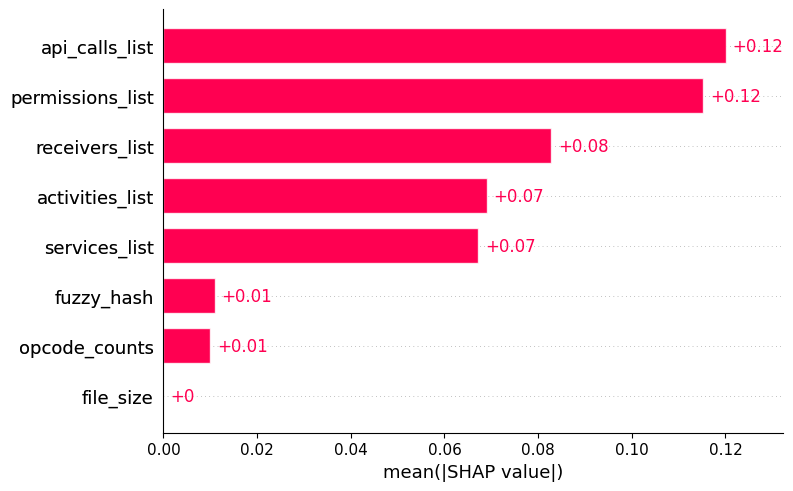


--- Beeswarm Plot (Feature Importance vs. Impact) ---


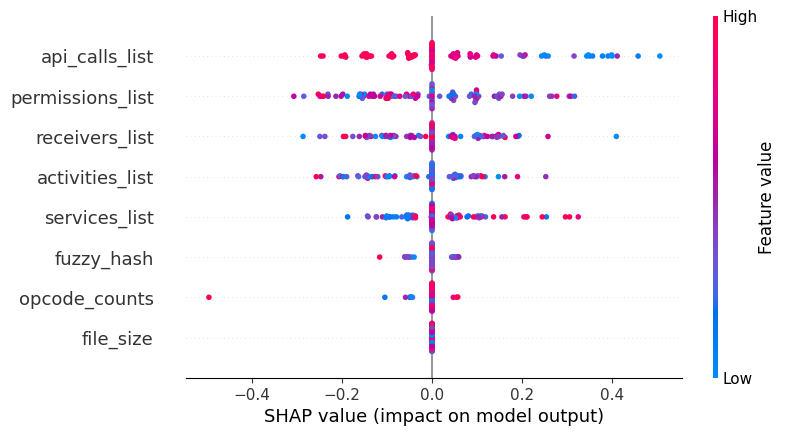


--- Heatmap Plot (Feature Importance across the Dataset) ---


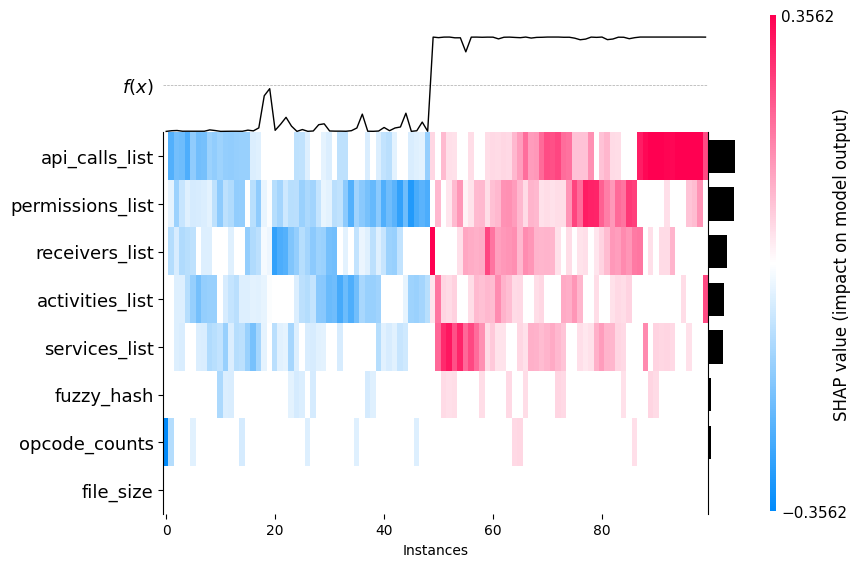


--- Stacked Force Plot (Explaining Multiple Predictions) ---


In [50]:
print("\n--- Interpreting the Importance of Original Features ---")
print("\n--- Bar Plot (Global Feature Importance) ---")
shap.plots.bar(explanation_positive_class, max_display=15)
plt.show()

print("\n--- Beeswarm Plot (Feature Importance vs. Impact) ---")
shap.plots.beeswarm(explanation_positive_class, max_display=15)
plt.show()

print("\n--- Heatmap Plot (Feature Importance across the Dataset) ---")
shap.plots.heatmap(explanation_positive_class, max_display=15)
plt.show()

print("\n--- Stacked Force Plot (Explaining Multiple Predictions) ---")
shap.plots.force(
    base_value=explanation_positive_class.base_values[1],
    shap_values=explanation_positive_class.values,
    features=explanation_positive_class.data,
    feature_names=explanation_positive_class.feature_names
)

[[0.01941938 0.98058057]]

--- Waterfall Plot (Explaining a Single Prediction) ---


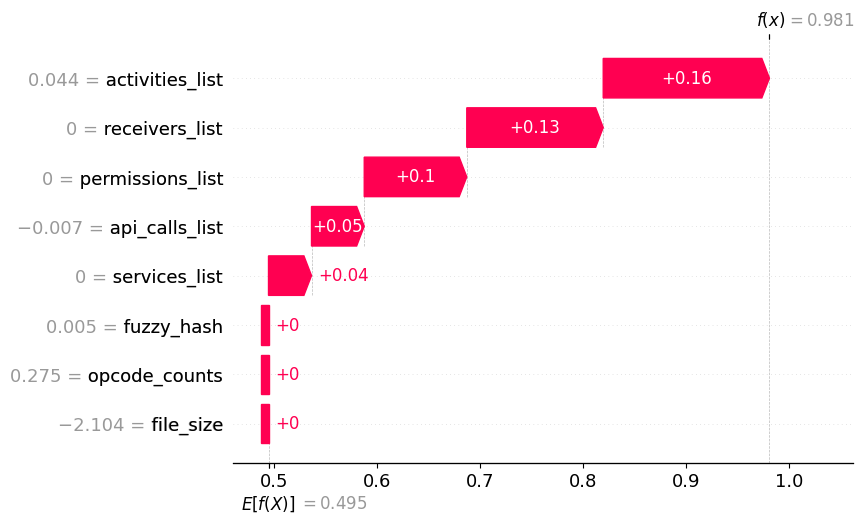


--- Force Plot (Explaining a Single Prediction) ---


In [53]:
prediction_value = 20

print(classifier_prediction_function(embeddings_to_explain[prediction_value:prediction_value + 1]))

print("\n--- Waterfall Plot (Explaining a Single Prediction) ---")
shap.plots.waterfall(explanation_positive_class[prediction_value], max_display=15)
plt.show()

print("\n--- Force Plot (Explaining a Single Prediction) ---")
shap.plots.force(explanation_positive_class[prediction_value])

In [42]:
aggregated_explanation[1]

.values =
array([[-0.04889952,  0.04889952],
       [-0.14493714,  0.14493713],
       [-0.09331078,  0.09331077],
       [-0.10834966,  0.10834965],
       [-0.05885613,  0.05885613],
       [-0.04694471,  0.0469447 ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ]])

.base_values =
np.float64(0.4947121644768231)

.data =
array([-0.00504997, -0.05747685, -0.04142949, -0.01674394, -0.00286873,
        0.00420489,  0.27824816, -2.10399652])


--- Dependency Plots (Feature Value vs. SHAP Value) ---

Dependency plot for 'api_calls_list'


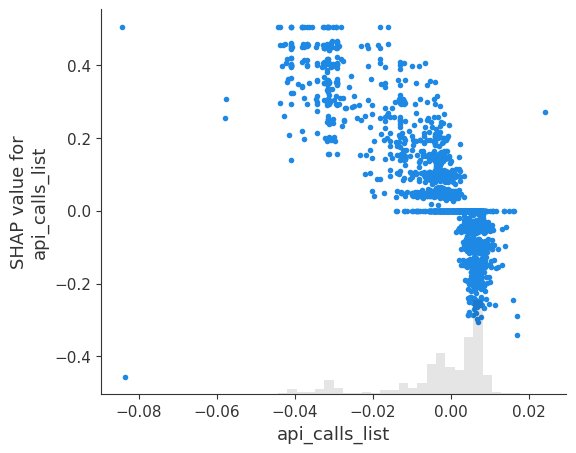


Dependency plot for 'api_calls_list' with interaction from 'permissions_list'


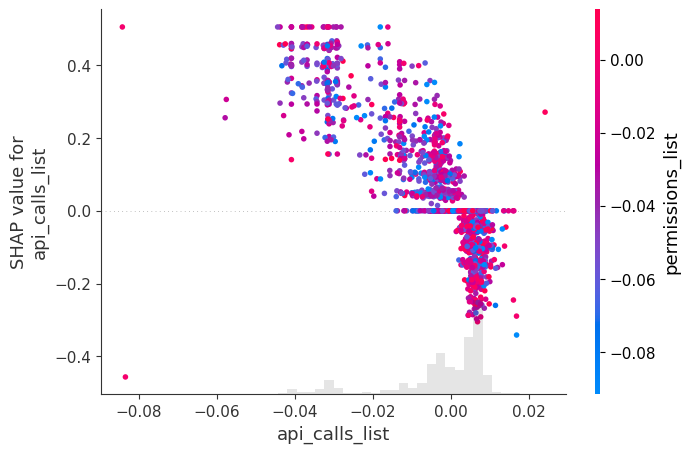


--- Dependency Plots for Top 4 Features ---

Plotting for feature: permissions_list


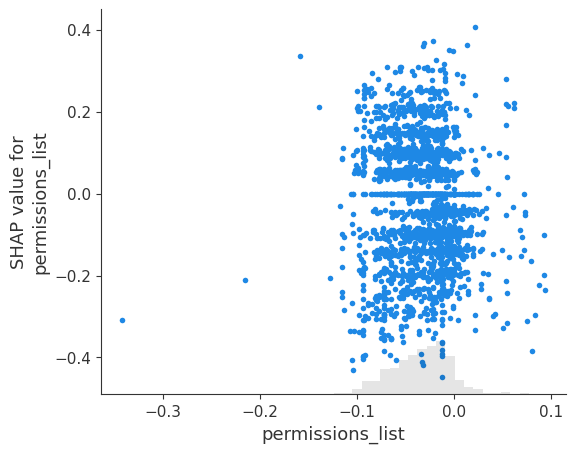


Plotting for feature: api_calls_list


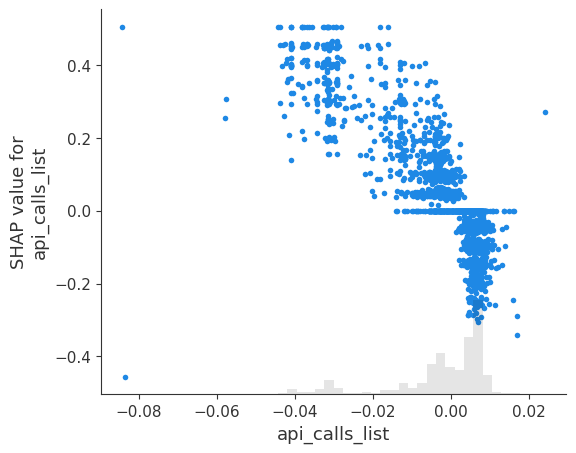


Plotting for feature: receivers_list


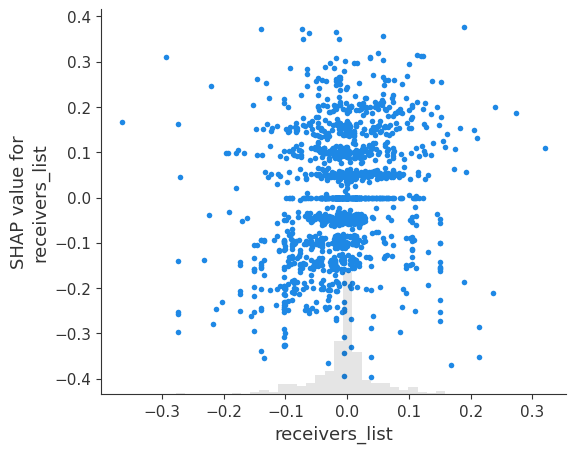


Plotting for feature: activities_list


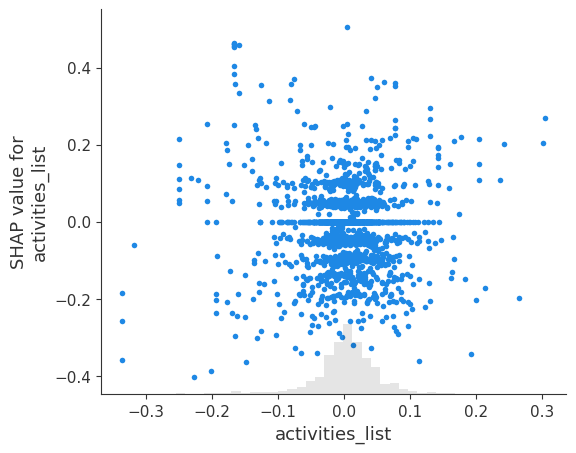

In [ ]:
# --- 6. Generate Dependency Plots ---
print("\n--- Dependency Plots (Feature Value vs. SHAP Value) ---")

# Dependency plots show how the value of a single feature (x-axis) affects
# its SHAP value (y-axis), which represents its impact on the model output.
# The color can be used to show interaction effects with a second feature.

# Get the list of feature names from the explanation object
feature_names = explanation_positive_class.feature_names

# --- Plot 1: Single Feature Dependency ---
# Let's look at the most important feature. SHAP will automatically pick
# another feature that it interacts with most for coloring.
# We assume 'api_calls_list' is a top feature.
top_feature = "api_calls_list"
print(f"\nDependency plot for '{top_feature}'")
shap.plots.scatter(explanation_positive_class[:, top_feature])
plt.show()


# --- Plot 2: Specifying the Interaction Feature ---
# You can also explicitly choose which feature to use for coloring to
# investigate specific interactions. For example, how do permissions
# affect the importance of API calls?
interaction_feature = "permissions_list"
print(f"\nDependency plot for '{top_feature}' with interaction from '{interaction_feature}'")
shap.plots.scatter(
    explanation_positive_class[:, top_feature],
    color=explanation_positive_class[:, interaction_feature]
)
plt.show()


# --- Plot 3: Automatically Plotting for Top Features ---
# It's useful to loop through the most important features.
# First, we find the top features by their mean absolute SHAP value.
mean_abs_shap = np.abs(explanation_positive_class.values).mean(axis=0)
top_feature_indices = np.argsort(mean_abs_shap)[::-1] # Sort in descending order

print("\n--- Dependency Plots for Top 4 Features ---")
for i in top_feature_indices[:4]:
    feature_name = feature_names[i]
    print(f"\nPlotting for feature: {feature_name}")
    shap.plots.scatter(explanation_positive_class[:, feature_name])
    plt.show()

Shape of embeddings to visualize: (100, 449)

Running UMAP to reduce dimensions...
UMAP transformation complete.


c:\Users\david\miniconda3\envs\python311\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\david\miniconda3\envs\python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


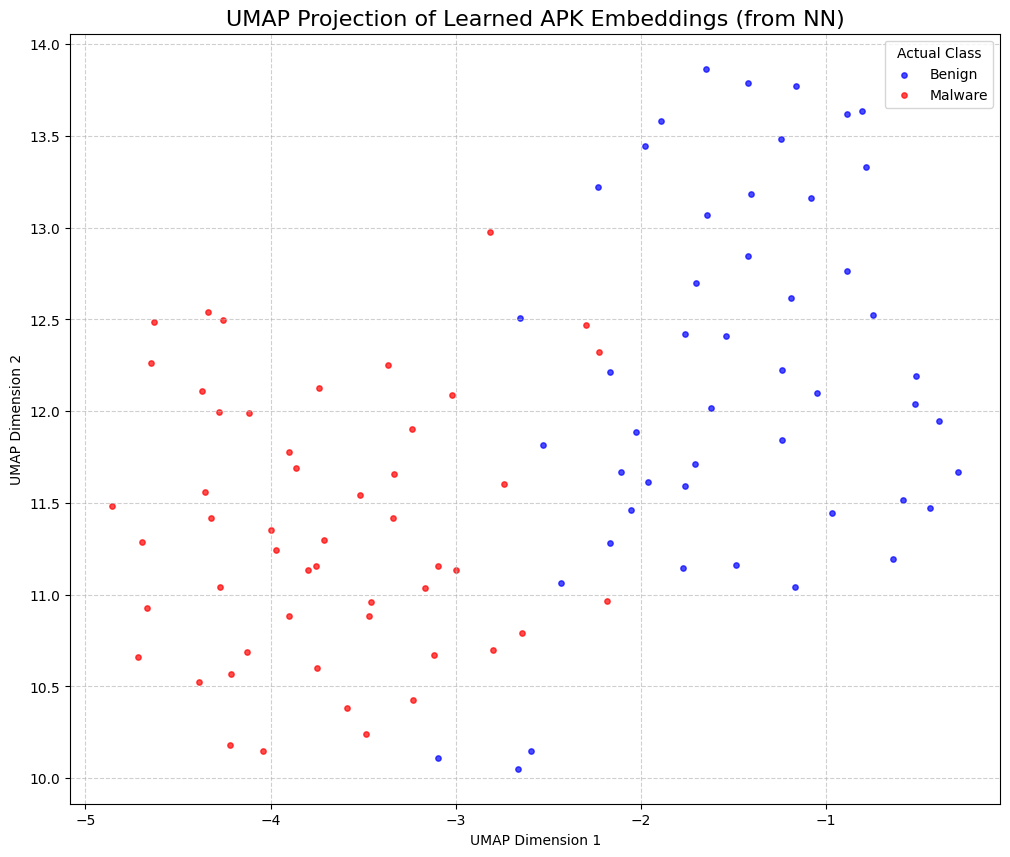

In [54]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
import pandas as pd

def plot_embedding_clusters(
    embedding_2d: np.ndarray,
    labels: pd.Series,
    title: str = 'UMAP Projection of Learned Embeddings'
):
    """
    Generates a 2D scatter plot of embeddings, colored by class labels.

    Args:
        embedding_2d: A NumPy array of shape (n_samples, 2) from UMAP.
        labels: A pandas Series or NumPy array with the true labels (0 or 1).
        title: The title for the plot.
    """
    plt.figure(figsize=(12, 10))

    malware_indices = (labels == 1)
    benign_indices = (labels == 0)

    # Plot benign samples
    plt.scatter(
        embedding_2d[benign_indices, 0],
        embedding_2d[benign_indices, 1],
        c='blue',
        label='Benign',
        alpha=0.7,
        s=15
    )

    # Plot malware samples
    plt.scatter(
        embedding_2d[malware_indices, 0],
        embedding_2d[malware_indices, 1],
        c='red',
        label='Malware',
        alpha=0.7,
        s=15
    )

    plt.title(title, fontsize=16)
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.legend(title='Actual Class')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
    
print(f"Shape of embeddings to visualize: {embeddings_to_explain.shape}")

# --- 2. Apply UMAP to reduce dimensionality ---
print("\nRunning UMAP to reduce dimensions...")
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding_2d = reducer.fit_transform(embeddings_to_explain)
print("UMAP transformation complete.")

# --- 3. Call the plotting function ---
plot_embedding_clusters(
    embedding_2d,
    df_explain['is_malware'],
    title='UMAP Projection of Learned APK Embeddings (from NN)'
)

# Part 2: SHAP Analysis for Classical ML Model (Random Forest & Logistic Regression)

In [12]:
from src.prototypes.ml_model_io import load_ml_model_from_version

# Load a pre-trained ML model. We'll assume a RandomForest was saved.
# The code will use the latest version available in the specified directory.
ml_model_name = "LogisticRegression"

try:
    ml_model, ml_metadata = load_ml_model_from_version(
        model_name=ml_model_name,
        base_dir=PATH_TO_SAVE_ML_MODEL
    )
    print(f"\nSuccessfully loaded '{ml_model_name}'")
    pp.pprint(ml_metadata['summary_metrics'])
except (FileNotFoundError, ValueError) as e:
    print(f"Could not load model '{ml_model_name}'. Please ensure it has been trained and saved.")
    print(f"Error: {e}")
    # Set to None to allow the notebook to run without error if the model is missing.
    ml_model = None

Loading latest model version: 20250626_211448
Loaded model 'LogisticRegression' from c:\Users\david\Desktop\Clase\TFG\tfg_24_25\model_artifacts\ml_models\20250626_211448

Successfully loaded 'LogisticRegression'
{'accuracy': 0.9860910203627462,
 'f1': 0.9860909879485188,
 'pr_auc': 0.9986994457391398,
 'precision': 0.9860951586245299,
 'recall': 0.9860910203627462,
 'roc_auc': 0.9987060941485281}


In [15]:
if ml_model:
    # For a model-agnostic approach that works with any model, we use KernelExplainer.
    # This is less efficient than TreeExplainer for tree models but is more general.
    print("Using shap.KernelExplainer for the RandomForest model.")

    # 1. Define the prediction function for the scikit-learn model.
    # This function must take a numpy array and return a numpy array of probabilities.
    def ml_model_prediction_function(x_numpy):
        # The model's predict_proba method already returns probabilities in the correct format.
        return ml_model.predict_proba(x_numpy)

    # 2. Reuse the analysis function to run KernelExplainer.
    # This function handles creating the explainer and calculating the SHAP values,
    # returning a consistent shap.Explanation object.
    ml_shap_values_obj = analyze_embeddings_with_shap(
        embeddings_to_explain=embeddings_to_explain,
        background_embeddings=background_embeddings,
        classifier_prediction_fn=ml_model_prediction_function
    )

    print("\nSHAP values calculated for ML model.")
    print("SHAP object shape:", ml_shap_values_obj.shape)

Using 128 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Using shap.KernelExplainer for the RandomForest model.
Creating background summary from 128 samples...
Calculating SHAP values for 100 instances...


  0%|          | 0/100 [00:00<?, ?it/s]

Done.

SHAP values calculated for ML model.
SHAP object shape: (100, 449, 2)


In [18]:
if ml_model:
    # We have SHAP values for the embedding dimensions. Now, aggregate them
    # back to the original feature level using the same function as before.
    
    ml_aggregated_explanation = aggregate_embedding_shap(
        embedding_explanation=ml_shap_values_obj,
        sequence_cols=SEQUENCE_COLS, char_cols=CHAR_COLS,
        vector_cols=VECTOR_COLS, scalar_cols=SCALAR_COLS,
        embedding_dim=embedding_dim # From the NN metadata, which is correct
    )

    # Select the SHAP values for the positive class (malware, index 1)
    ml_explanation_positive_class = ml_aggregated_explanation[:, :, 1]

    print("\n--- Aggregated SHAP Explanation for ML Model ---")
    print("Shape of aggregated SHAP values:", ml_explanation_positive_class.values.shape)
    print("Feature names:", ml_explanation_positive_class.feature_names)


--- Aggregated SHAP Explanation for ML Model ---
Shape of aggregated SHAP values: (100, 8)
Feature names: ['activities_list', 'services_list', 'receivers_list', 'permissions_list', 'api_calls_list', 'fuzzy_hash', 'opcode_counts', 'file_size']


In [19]:
if ml_model:
    print("\n--- Agregated Force Plot (Explaining Multiple Predictions) ---")
    shap.plots.force(
        base_value=ml_explanation_positive_class.base_values[1],
        shap_values=ml_explanation_positive_class.values,
        features=ml_explanation_positive_class.data,
        feature_names=ml_explanation_positive_class.feature_names
    )


--- Agregated Force Plot (Explaining Multiple Predictions) ---



--- Interpretation Plots for LogisticRegression ---

--- Bar Plot (Global Feature Importance) ---


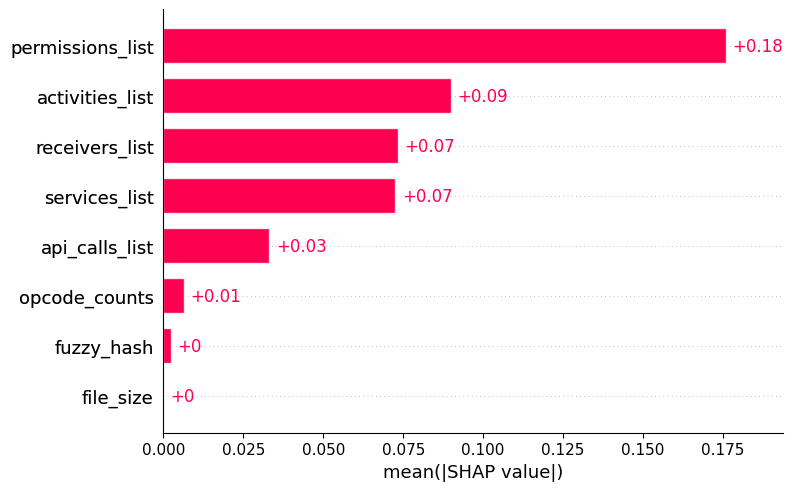


--- Beeswarm Plot (Feature Importance vs. Impact) ---


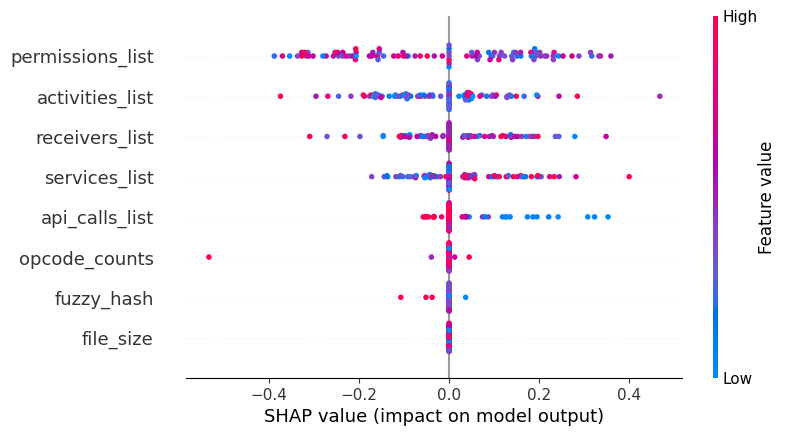


--- Waterfall Plot (Explaining a Single Prediction) ---


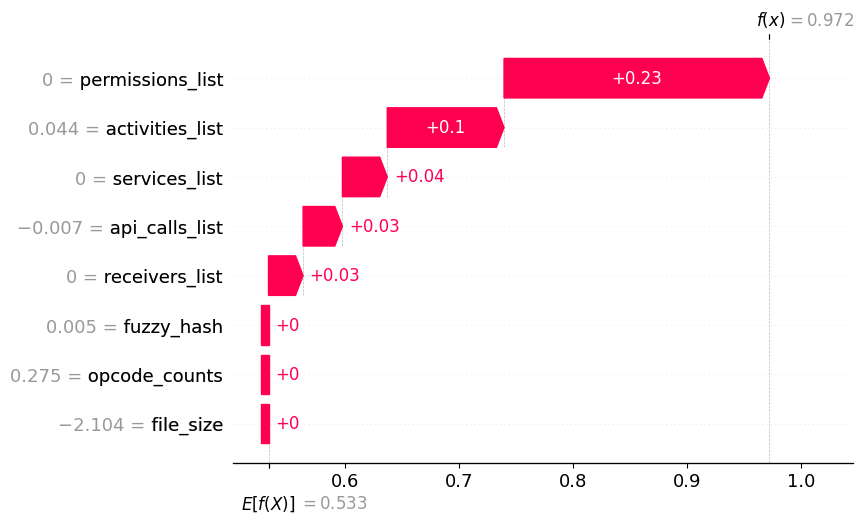


--- Dependency Plots for Top 4 Features ---

Plotting for feature: permissions_list


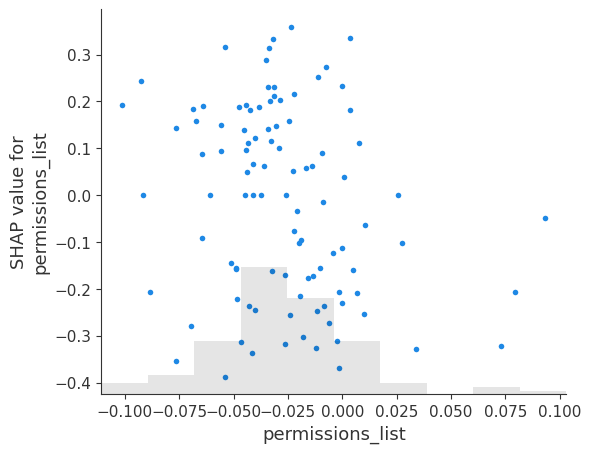


Plotting for feature: activities_list


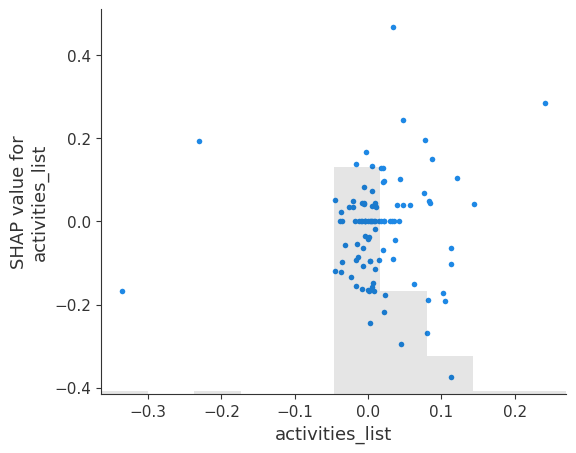


Plotting for feature: receivers_list


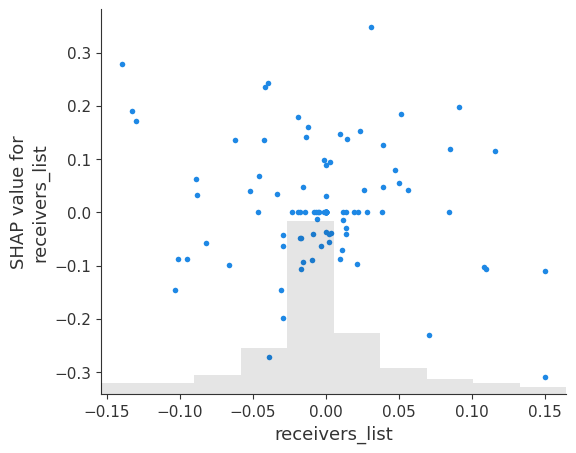


Plotting for feature: services_list


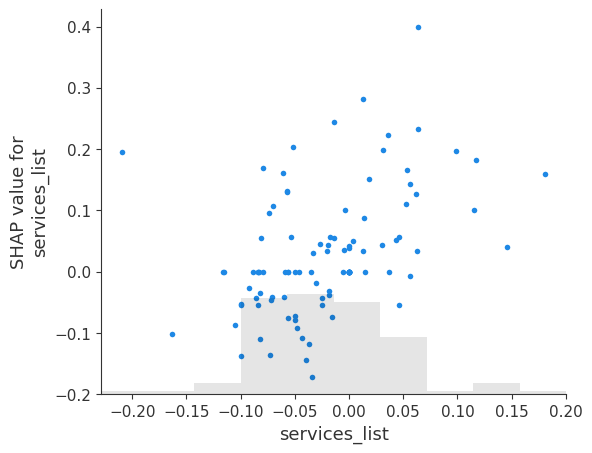

In [20]:
if ml_model:
    print(f"\n--- Interpretation Plots for {ml_model_name} ---")

    print("\n--- Bar Plot (Global Feature Importance) ---")
    shap.plots.bar(ml_explanation_positive_class, max_display=15)
    plt.show()

    print("\n--- Beeswarm Plot (Feature Importance vs. Impact) ---")
    shap.plots.beeswarm(ml_explanation_positive_class, max_display=15)
    plt.show()
    
    print("\n--- Waterfall Plot (Explaining a Single Prediction) ---")
    # Explain the same sample as before for a direct comparison
    prediction_value = 20
    shap.plots.waterfall(ml_explanation_positive_class[prediction_value], max_display=15)
    plt.show()

    print("\n--- Dependency Plots for Top 4 Features ---")
    feature_names = ml_explanation_positive_class.feature_names
    # Find top features by mean absolute SHAP value
    mean_abs_shap = np.abs(ml_explanation_positive_class.values).mean(axis=0)
    top_feature_indices = np.argsort(mean_abs_shap)[::-1]

    for i in top_feature_indices[:4]:
        feature_name = feature_names[i]
        print(f"\nPlotting for feature: {feature_name}")
        shap.plots.scatter(ml_explanation_positive_class[:, feature_name])
        plt.show()